In [1]:
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
from torch.utils.data import Dataset
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import pandas as pd 


import torch.nn.functional as F

## Load data

In [2]:
#/Users/laurabraadrasmussen/Documents/UNI/5. semester/Deep Learning/Projekt/Data
train_data = pd.read_csv('../Data/training.csv')
test_data = pd.read_csv('../Data/test.csv')
id_lookup_data = pd.read_csv('../Data/IdLookupTable.csv')


In [3]:
train_data.iloc[1]

left_eye_center_x                                                    64.332936
left_eye_center_y                                                    34.970077
right_eye_center_x                                                   29.949277
right_eye_center_y                                                   33.448715
left_eye_inner_corner_x                                               58.85617
left_eye_inner_corner_y                                              35.274349
left_eye_outer_corner_x                                              70.722723
left_eye_outer_corner_y                                              36.187166
right_eye_inner_corner_x                                             36.034723
right_eye_inner_corner_y                                             34.361532
right_eye_outer_corner_x                                             24.472511
right_eye_outer_corner_y                                             33.144443
left_eyebrow_inner_end_x                            

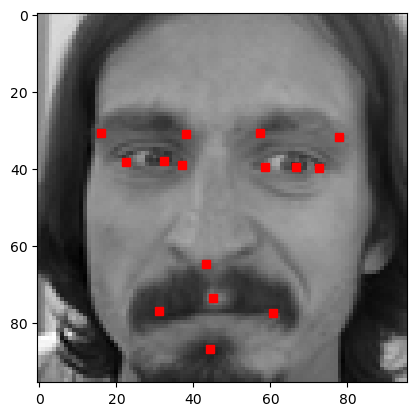

In [4]:
def get_image_and_keypoints(series):
    image = series['Image']
    image = np.fromstring(image, sep=' ').reshape([96, 96]) / 255.0
    keypoints = pd.DataFrame(series).drop(['Image'], axis=0).values.reshape([15, 2])
    return image, keypoints

def get_image_and_keypoints_by_id(train_data, id):
    series = train_data.iloc[id]
    return get_image_and_keypoints(series)


def show_image_with_keypoints(series):
    image, keypoints = get_image_and_keypoints(series)
    plt.imshow(image, cmap='gray')
    plt.plot(keypoints[:, 0], keypoints[:, 1], 'rs')


def show_image_with_keypoints_by_id(train_data, id):
    series = train_data.iloc[id]
    show_image_with_keypoints(series)
    
show_image_with_keypoints_by_id(train_data, 4)

## Data preprocessing

In [5]:
# Fjerner NA i dataset
train_data = train_data.dropna()
len(train_data)

2140

In [6]:
# 200 random samples
train_data_200 = train_data.sample(n = 200)

In [7]:
#train_data_200[:1].left_eye_center_x

In [8]:
#train_data_200.iloc[8]


## Model

In [9]:
x_coordinat = []
y_coordinat = []

for i in range(0,30,2):
    x_coordinat.append(train_data_200.iloc[1][i])
    y_coordinat.append(train_data_200.iloc[1][i+1])


In [10]:
#make data iterator for spiral dataset

class imageDataset(Dataset):
 
  def __init__(self, file_name):
    labels=[file_name.iloc[i].values[0:30] for i in range(len(train_data_200))]
    inputs=[file_name.iloc[i].values[30:31] for i in range(len(train_data_200))]
    
    inputs = [(i[0].split()) for i in inputs]
    inputs = [[int(i) for i in j] for j in inputs] 
    inputs = [np.reshape(i, (96,96)) for i in inputs]
    inputs = [np.expand_dims(i,0) for i in inputs]
    
    
    
    #print(inputs[0])
    #print(type(inputs[1]))
    self.labels=torch.tensor(labels,dtype=torch.float32) #convert to torch floats otherwise 
    self.inputs=torch.tensor(inputs, dtype=torch.float) #we will get an error message
 
  def __len__(self):
    return len(self.labels)
   
  def __getitem__(self, idx):
    return self.inputs[idx], self.labels[idx]
    



In [11]:
data = imageDataset(train_data_200)

/Users/laurabraadrasmussen/opt/anaconda3/envs/slml/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_croot-udngs7fm/pytorch_1648016055234/work/torch/csrc/utils/tensor_new.cpp:201.)


In [12]:
batch_size = 200
#Convert to tensors
x_train = data.inputs
y_train = data.labels
#x_test = torch.tensor(x_test_org)
#y_test = torch.tensor(y_test_org)

trainset = torch.utils.data.TensorDataset(x_train, y_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

#testset = torch.utils.data.TensorDataset(x_test, y_test)
#testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size)

In [13]:
input_shape = x_train[0].shape
print('input_shape :',input_shape)

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
#print(x_test.shape[0], 'test samples')

# to_categorical converts class indices to one-hot vectors
print('y_train shape:', y_train.shape)

input_shape : torch.Size([1, 96, 96])
x_train shape: torch.Size([200, 1, 96, 96])
200 train samples
y_train shape: torch.Size([200, 30])


In [14]:
#%% make network
num_classes = 30


#something simple like cnn-cnn-fc-relu-fc will do

# define network
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.relu = torch.relu
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding='same')
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=256, kernel_size=3, padding='same')
        self.fc1 = nn.Linear(256*24*24, 1024)
        self.FC1 = nn.Linear(1024, 128)  
        self.FC2 = nn.Linear(128, num_classes)  
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
    
        
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        
        x = x.view(-1, 256*24*24)
        
        x = self.fc1(x)
        x = F.relu(x)
 
        
        x = self.FC1(x)
        x = F.relu(x)
        x = self.FC2(x)
        
        return x

net = NeuralNetwork()

In [15]:
#criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss()
#optimizer = optim.SGD(fcn.parameters(), lr=0.1)
optimizer = optim.Adam(net.parameters(), lr=0.1)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5) # decrease LR every two steps

nEpocs = 30 # How many times should we run over the data set?
totaliter = 0
net.train()
for epoch in range(nEpocs):  # loop over the dataset multiple times
    #print('epoch',epoch)
    running_loss = 0.0
    
    #scheduler.step()
    
    for i, data in enumerate(trainloader, 0):
        totaliter+=1
        
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize      
        outputs = net(inputs)
        outputs_reshape = outputs.view(outputs.shape[0],-1)
        loss = criterion(outputs_reshape, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        

    print('Epoch %d, Train loss: %.3f' %(epoch + 1, running_loss / 100))
            
    running_loss = 0.0
print('Finished Training')
net.eval()

Epoch 1, Train loss: 26.650
Epoch 2, Train loss: 98330119440957.438
Epoch 3, Train loss: 45767797.760
Epoch 4, Train loss: 3581.832
Epoch 5, Train loss: 127.535
Epoch 6, Train loss: 155.650
Epoch 7, Train loss: 24.622
Epoch 8, Train loss: 23.700
Epoch 9, Train loss: 22.626
Epoch 10, Train loss: 21.545
Epoch 11, Train loss: 20.429
Epoch 12, Train loss: 19.302
Epoch 13, Train loss: 18.161
Epoch 14, Train loss: 17.027
Epoch 15, Train loss: 15.941
Epoch 16, Train loss: 14.901
Epoch 17, Train loss: 13.872
Epoch 18, Train loss: 12.848
Epoch 19, Train loss: 11.817
Epoch 20, Train loss: 10.786
Epoch 21, Train loss: 9.757
Epoch 22, Train loss: 8.735
Epoch 23, Train loss: 7.730
Epoch 24, Train loss: 6.762
Epoch 25, Train loss: 5.853
Epoch 26, Train loss: 5.037
Epoch 27, Train loss: 4.350
Epoch 28, Train loss: 3.837
Epoch 29, Train loss: 3.538
Epoch 30, Train loss: 3.483
Finished Training


NeuralNetwork(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2): Conv2d(8, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (fc1): Linear(in_features=147456, out_features=1024, bias=True)
  (FC1): Linear(in_features=1024, out_features=128, bias=True)
  (FC2): Linear(in_features=128, out_features=30, bias=True)
)

In [25]:
train_data_200.iloc[43]

left_eye_center_x                                                    64.152828
left_eye_center_y                                                    37.754152
right_eye_center_x                                                   30.024166
right_eye_center_y                                                   35.449821
left_eye_inner_corner_x                                              57.096828
left_eye_inner_corner_y                                              39.770152
left_eye_outer_corner_x                                               73.59989
left_eye_outer_corner_y                                              39.069683
right_eye_inner_corner_x                                             38.676745
right_eye_inner_corner_y                                             37.658483
right_eye_outer_corner_x                                             21.095834
right_eye_outer_corner_y                                             35.017821
left_eyebrow_inner_end_x                            

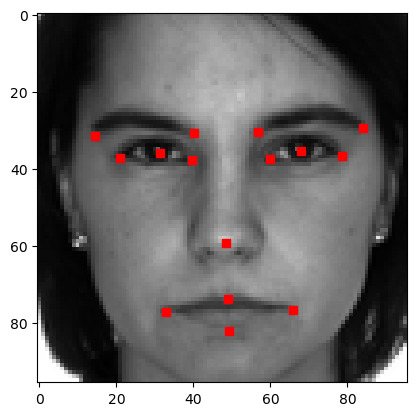

In [26]:
show_image_with_keypoints_by_id(train_data,1533)

[[48.96606827 46.41856766]
 [51.56332016 47.40408707]
 [50.65659714 48.29874039]
 [49.85879135 48.41387939]
 [49.98497009 43.80068588]
 [46.97743988 47.28995132]
 [49.30270767 48.82031631]
 [47.83473206 48.00046539]
 [51.10554123 46.86652756]
 [50.23408508 48.38768387]
 [49.5620842  51.96303177]
 [52.04925537 50.78054428]
 [47.14635468 47.02243423]
 [44.30102539 48.33444595]
 [49.72650146 47.40261459]]


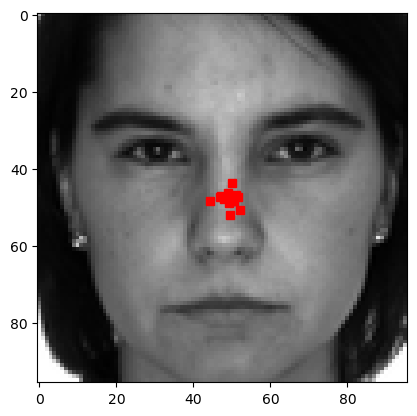

In [27]:

def get_image_and_keypoints2(series):
    image = series['Image']
    image = np.fromstring(image, sep=' ').reshape([96, 96]) / 255.0
    keypoints = pd.DataFrame(outputs[43].tolist()).values.reshape([15, 2])
    print(keypoints)
    return image, keypoints

def get_image_and_keypoints_by_id2(train_data, id):
    series = train_data.iloc[id]
    return get_image_and_keypoints2(series)


def show_image_with_keypoints2(series):
    image, keypoints = get_image_and_keypoints2(series)
    plt.imshow(image, cmap='gray')
    plt.plot(keypoints[:, 0], keypoints[:, 1], 'rs')


def show_image_with_keypoints_by_id2(train_data, id):
    series = train_data.iloc[id]
    show_image_with_keypoints2(series)
    
show_image_with_keypoints_by_id2(train_data, 1533)